In [1]:
import cimpy
from cimpy import CIM2DPsim
from cimpy.CIM2DPsim import Domain
from cimpy.cgmes_v2_4_15.Base import short_profile_name
import os
from pathlib import Path

import sys
sys.path.insert(0,'/home/mmo/git/Can/dpsim/build')
import dpsimpy

example_dir = Path(os.path.join('../cimpy/examples/sampledata/IEEE14')).resolve()

test_files = []
for file in example_dir.glob('*.xml'):
    test_files.append(str(file.absolute()))

imported_result = cimpy.cim_import(test_files, 'cgmes_v2_4_15')

CIM object Diagram created : 1 times
CIM object DiagramObjectPoint created : 168 times
CIM object DiagramObject created : 77 times
CIM object SvPowerFlow created : 16 times
CIM object SvVoltage created : 14 times
CIM object SvTapStep created : 5 times
CIM object TopologicalIsland created : 1 times
CIM object TopologicalNode created : 14 times
CIM object VoltageLimit created : 14 times
CIM object Terminal created : 58 times
CIM object VoltageLevel created : 14 times
CIM object OperationalLimitSet created : 56 times
CIM object PowerTransformer created : 5 times
CIM object ConformLoad created : 11 times
CIM object SubGeographicalRegion created : 1 times
CIM object RegulatingControl created : 5 times
CIM object BaseVoltage created : 4 times
CIM object PowerTransformerEnd created : 10 times
CIM object CurrentLimit created : 42 times
CIM object LoadArea created : 1 times
CIM object ConformLoadGroup created : 1 times
CIM object OperationalLimitType created : 2 times
CIM object RatioTapChanger

### Run Powerflow Simulation

In [2]:
name_pf = "IEEE14_ReaderTest_PF"
dpsimpy.Logger.set_log_dir("logs/" + name_pf)

# create dpsim topology from cimpy object
system_PF = CIM2DPsim.CIM2DPsim(imported_result, Domain.PF, log_level=dpsimpy.LogLevel.info)

#set slack
system_PF.component("Gen_0001").modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

sim_pf = dpsimpy.Simulation(name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_PF)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
#sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.do_init_from_nodes_and_terminals(False)

logger = dpsimpy.Logger(name_pf)
sim_pf.add_logger(logger)
for node in system_PF.nodes:
    logger.log_attribute(node.name+'.V', 'v', node)
    logger.log_attribute(node.name+'.S', 's', node)
    
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.5)
sim_pf.run()

[18:21:29.673639 IEEE14_ReaderTest_PF info] Initialize simulation: IEEE14_ReaderTest_PF
[18:21:29.674303 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0010
[18:21:29.674311 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0014
[18:21:29.674314 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0011
[18:21:29.674317 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0002
[18:21:29.674325 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0012
[18:21:29.674329 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0003
[18:21:29.674331 IEEE14_ReaderTest_PF_PF_Solver warning] Unable to get base voltage at Bus_0013
[18:21:29.674742 IEEE14_ReaderTest_PF info] Scheduling tasks.
[18:21:29.674966 IEEE14_ReaderTest_PF info] Scheduling done.
[18:21:29.674969 IEEE14_ReaderTest_PF info] Opening interfaces.
[18:21:29.674971 IEEE14_ReaderTest_PF info] Start syn

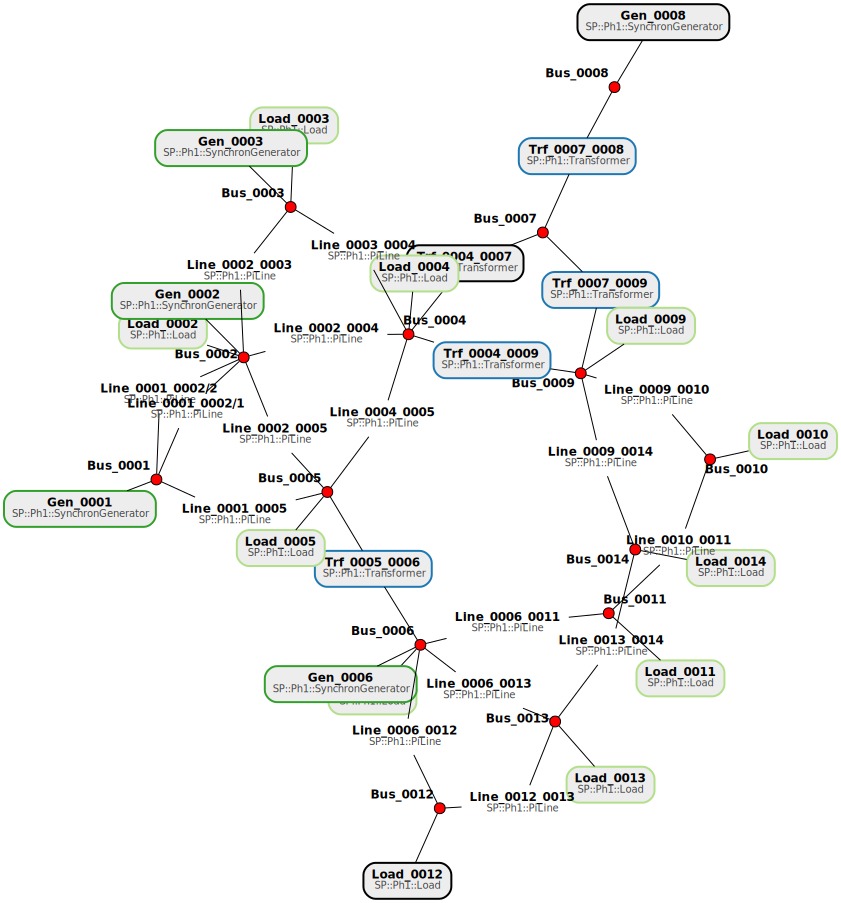

In [3]:
system_PF

### Read of results

In [4]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
import urllib.request
import matplotlib.pyplot as plt

dpsim_result_file = 'logs/' + name_pf + '/' + name_pf + '.csv'
ts_dpsim_pf = read_timeseries_csv(dpsim_result_file)

column number: 28
results length: 6
real column names: []
complex column names: ['Bus_0001.S', 'Bus_0001.V', 'Bus_0002.S', 'Bus_0002.V', 'Bus_0003.S', 'Bus_0003.V', 'Bus_0004.S', 'Bus_0004.V', 'Bus_0005.S', 'Bus_0005.V', 'Bus_0006.S', 'Bus_0006.V', 'Bus_0007.S', 'Bus_0007.V', 'Bus_0008.S', 'Bus_0008.V', 'Bus_0009.S', 'Bus_0009.V', 'Bus_0010.S', 'Bus_0010.V', 'Bus_0011.S', 'Bus_0011.V', 'Bus_0012.S', 'Bus_0012.V', 'Bus_0013.S', 'Bus_0013.V', 'Bus_0014.S', 'Bus_0014.V']


In [5]:
dpsim_results = pd.DataFrame(columns=['Bus', 'Vmag [kV]', 'Vangle [rad]', 'P [MW]', 'Q [MVAr]'])
base_power = 100 #mw
for i in range(len(system_PF.nodes)):
    node_name = system_PF.nodes[i].name
    w_mw = 1e-6
    dpsim_results.loc[i] = ([node_name] + [round(np.absolute(ts_dpsim_pf[node_name + '.V'].values[-1]) / 1000, 4)]
        + [round(np.angle(ts_dpsim_pf[node_name + '.V'].values[-1]), 4)] 
        + [round(w_mw * np.real(ts_dpsim_pf[node_name + '.S'].values[-1]), 4)] 
        + [round(w_mw * np.imag(ts_dpsim_pf[node_name + '.S'].values[-1]), 5)])

dpsim_results



,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,1.0452,-0.2349,-0.0000,0.00000
1,Bus_0001,139.9200,0.0000,232.5296,-22.86087
2,Bus_0004,135.5735,-0.1811,-47.8000,3.90000
3,Bus_0010,33.9201,-0.2675,-9.0000,-5.80000
4,Bus_0014,33.5839,-0.2862,-14.9000,-5.00000
5,Bus_0011,34.4888,-0.2656,-3.5000,-1.80000
6,Bus_0002,137.9400,-0.0865,18.3000,16.86303
7,Bus_0009,33.9253,-0.2632,-29.5000,-16.60000
8,Bus_0006,35.3100,-0.2597,-11.2000,41.14281
9,Bus_0008,11.9900,-0.2349,-0.0000,27.69623


In [6]:
# get powerfactory results
pf_results = CIM2DPsim.get_powerflow_results(imported_result)
pf_results

,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,1.04524,-0.234906,0.0000,0.0000
1,Bus_0001,139.92000,0.000000,232.5290,-22.8611
2,Bus_0004,135.57400,-0.181125,-47.8000,3.9000
3,Bus_0010,33.92010,-0.267473,-9.0000,-5.8000
4,Bus_0014,33.58390,-0.286218,-14.9000,-5.0000
5,Bus_0011,34.48880,-0.265601,-3.5000,-1.8000
6,Bus_0002,137.94000,-0.086481,18.3001,16.8627
7,Bus_0009,33.92530,-0.263161,-29.5000,-16.6000
8,Bus_0006,35.31000,-0.259719,-11.2000,41.1425
9,Bus_0008,11.99000,-0.234904,0.0000,27.6962


### Difference between PowerFactory and DPsim

In [7]:
difference_vmag = pf_results['Vmag [kV]'] - dpsim_results['Vmag [kV]']
difference_vangle = pf_results['Vangle [rad]'] - dpsim_results['Vangle [rad]']

#base power = 100MW
difference_p = (pf_results['P [MW]'] - dpsim_results['P [MW]'])
difference_q = (pf_results['Q [MVAr]'] - dpsim_results['Q [MVAr]'])
difference = {"Bus": pf_results['Bus'], "Vmag [kV]": difference_vmag, "Vangle [rad]": difference_vangle, "P [MW]": difference_p, "Q [MVAr]": difference_q}
difference = pd.DataFrame(difference)

difference

,Bus,Vmag [kV],Vangle [rad],P [MW],Q [MVAr]
0,Bus_0007,0.00004,-5.609355e-06,0.0000,0.00000
1,Bus_0001,0.00000,0.000000e+00,-0.0006,-0.00023
2,Bus_0004,0.00050,-2.503378e-05,0.0000,0.00000
3,Bus_0010,0.00000,2.654680e-05,0.0000,0.00000
4,Bus_0014,0.00000,-1.828936e-05,0.0000,0.00000
5,Bus_0011,0.00000,-7.149100e-07,0.0000,0.00000
6,Bus_0002,0.00000,1.911010e-05,0.0001,-0.00033
7,Bus_0009,0.00000,3.925538e-05,0.0000,0.00000
8,Bus_0006,0.00000,-1.895533e-05,0.0000,-0.00031
9,Bus_0008,0.00000,-3.864026e-06,0.0000,-0.00003


### Run dynamic simulation

In [8]:
def simulate_ieee14(system_PF, domain=Domain.DP):
    domain_dpsimpy = None
    name_dyn = ""
    if (domain==Domain.SP):
        domain_dpsimpy = dpsimpy.Domain.SP
        name_dyn = "IEEE14_ReaderTest_Dyn_SP"
    elif (domain==Domain.DP):
        domain_dpsimpy = dpsimpy.Domain.DP
        name_dyn = "IEEE14_ReaderTest_Dyn_DP"
    elif (domain==Domain.EMT):
        domain_dpsimpy = dpsimpy.Domain.EMT
        name_dyn = "IEEE14_ReaderTest_Dyn_EMT"

    dpsimpy.Logger.set_log_dir("logs/" + name_dyn)
    
    # create dpsim topology from cimpy object
    system = CIM2DPsim.CIM2DPsim(imported_result, domain, log_level=dpsimpy.LogLevel.debug, gen_model=CIM2DPsim.SGModels.VBR_6Order)
    
    ### Extend topology with switch between node N14 and ground
    sw = None
    switch_closed = 0.001
    if (domain==Domain.SP):
        sw = dpsimpy.sp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
        sw.set_parameters(1e18, switch_closed)
        sw.open()
        system.add(sw)
        system.connect_component(sw, [dpsimpy.sp.SimNode.gnd, system.node("Bus_0014")])
    elif (domain==Domain.DP):
        sw = dpsimpy.dp.ph1.Switch('Fault', dpsimpy.LogLevel.info)
        sw.set_parameters(1e18, switch_closed)
        sw.open()
        system.add(sw)
        system.connect_component(sw, [dpsimpy.dp.SimNode.gnd, system.node("Bus_0014")])
    elif (domain==Domain.EMT):
        sw = dpsimpy.emt.ph3.SeriesSwitch('Fault', dpsimpy.LogLevel.info)
        sw.set_parameters(1e18, switch_closed)
        sw.open()
        system.add(sw)
        system.connect_component(sw, [dpsimpy.emt.SimNode.gnd, system.node("Bus_0014")])
    
    # run simulation
    sim = dpsimpy.Simulation(name_dyn, dpsimpy.LogLevel.info)
    sim.set_system(system)
    sim.set_domain(domain_dpsimpy)
    
    sim.do_init_from_nodes_and_terminals(True)
    sim.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)
    sim.do_system_matrix_recomputation(True)
    
    # initialize node voltages of dynamic system
    system.init_with_powerflow(systemPF=system_PF, domain=domain_dpsimpy)
    
    logger = dpsimpy.Logger(name_dyn)
    sim.add_logger(logger)
    for node in system.nodes:
        logger.log_attribute(node.name+'.V', 'v', node)
        
    sim.set_time_step(1e-4)
    sim.set_final_time(5)
    
    # add events
    sw_event_1 = dpsimpy.event.SwitchEvent(1, sw, True)
    sw_event_2 = dpsimpy.event.SwitchEvent(1.1, sw, False)
    sim.add_event(sw_event_1)
    sim.add_event(sw_event_2)
    
    sim.run()
    
    return name_dyn, system

In [9]:
name_dyn_emt, system = simulate_ieee14(system_PF, domain=Domain.EMT)

1.000000e+00: Handle event time
1.100000e+00: Handle event time


[18:21:30.250684 IEEE14_ReaderTest_Dyn_EMT info] Initialize simulation: IEEE14_ReaderTest_Dyn_EMT
[18:21:30.250950 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:21:30.272410 IEEE14_ReaderTest_Dyn_EMT_Solver warning] Linear solver configuration is not used!
[18:21:30.282446 IEEE14_ReaderTest_Dyn_EMT info] Scheduling tasks.
[18:21:30.283060 IEEE14_ReaderTest_Dyn_EMT info] Scheduling done.
[18:21:30.283064 IEEE14_ReaderTest_Dyn_EMT info] Opening interfaces.
[18:21:30.283065 IEEE14_ReaderTest_Dyn_EMT info] Start synchronization with remotes on interfaces
[18:21:30.283066 IEEE14_ReaderTest_Dyn_EMT info] Synchronized simulation start with remotes
[18:21:30.283068 IEEE14_ReaderTest_Dyn_EMT info] Start simulation: IEEE14_ReaderTest_Dyn_EMT
[18:21:30.283071 IEEE14_ReaderTest_Dyn_EMT info] Time step: 1.000000e-04
[18:21:30.283074 IEEE14_ReaderTest_Dyn_EMT info] Final time: 5.000000e+00
[18:21:34.610444 IEEE14_ReaderTest_Dyn_EMT info] Simulation calculation time: 4.327

In [10]:
name_dyn_dp, system = simulate_ieee14(system_PF, domain=Domain.DP)

1.000000e+00: Handle event time
1.100000e+00: Handle event time


[18:21:34.690679 IEEE14_ReaderTest_Dyn_DP info] Initialize simulation: IEEE14_ReaderTest_Dyn_DP
[18:21:34.690783 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:21:34.711624 IEEE14_ReaderTest_Dyn_DP_Solver warning] Linear solver configuration is not used!
[18:21:34.717027 IEEE14_ReaderTest_Dyn_DP info] Scheduling tasks.
[18:21:34.717782 IEEE14_ReaderTest_Dyn_DP info] Scheduling done.
[18:21:34.717786 IEEE14_ReaderTest_Dyn_DP info] Opening interfaces.
[18:21:34.717787 IEEE14_ReaderTest_Dyn_DP info] Start synchronization with remotes on interfaces
[18:21:34.717789 IEEE14_ReaderTest_Dyn_DP info] Synchronized simulation start with remotes
[18:21:34.717791 IEEE14_ReaderTest_Dyn_DP info] Start simulation: IEEE14_ReaderTest_Dyn_DP
[18:21:34.717793 IEEE14_ReaderTest_Dyn_DP info] Time step: 1.000000e-04
[18:21:34.717796 IEEE14_ReaderTest_Dyn_DP info] Final time: 5.000000e+00
[18:21:37.115421 IEEE14_ReaderTest_Dyn_DP info] Simulation calculation time: 2.397561
[18:21:37

In [11]:
name_dyn_sp, system = simulate_ieee14(system_PF, domain=Domain.SP)

1.000000e+00: Handle event time


[18:21:37.172373 IEEE14_ReaderTest_Dyn_SP info] Initialize simulation: IEEE14_ReaderTest_Dyn_SP
[18:21:37.172477 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[18:21:37.175752 IEEE14_ReaderTest_Dyn_SP_Solver warning] Linear solver configuration is not used!
[18:21:37.179160 IEEE14_ReaderTest_Dyn_SP info] Scheduling tasks.
[18:21:37.179449 IEEE14_ReaderTest_Dyn_SP info] Scheduling done.
[18:21:37.179452 IEEE14_ReaderTest_Dyn_SP info] Opening interfaces.
[18:21:37.179453 IEEE14_ReaderTest_Dyn_SP info] Start synchronization with remotes on interfaces
[18:21:37.179454 IEEE14_ReaderTest_Dyn_SP info] Synchronized simulation start with remotes
[18:21:37.179455 IEEE14_ReaderTest_Dyn_SP info] Start simulation: IEEE14_ReaderTest_Dyn_SP
[18:21:37.179457 IEEE14_ReaderTest_Dyn_SP info] Time step: 1.000000e-04
[18:21:37.179460 IEEE14_ReaderTest_Dyn_SP info] Final time: 5.000000e+00
[18:21:39.242935 IEEE14_ReaderTest_Dyn_SP info] Simulation calculation time: 2.063420
[18:21:39

1.100000e+00: Handle event time


### Read results

In [12]:
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *

# read dpsim log files
file_path = os.getcwd() + "/logs/" + name_dyn_emt + "/" + name_dyn_emt + ".csv"
ts_dpsim_emt = read_timeseries_dpsim(file_path)

file_path = os.getcwd() + "/logs/" + name_dyn_sp + "/" + name_dyn_sp + ".csv"
ts_dpsim_sp = read_timeseries_dpsim(file_path)

file_path = os.getcwd() + "/logs/" + name_dyn_dp + "/" + name_dyn_dp + ".csv"
ts_dpsim_dp = read_timeseries_dpsim(file_path)

#powerfactory results
digsilent_result_file = "/home/mmo/git/Can/cimpy/cimpy/PF_results.csv"
ts_powerfactory = read_timeseries_csv(digsilent_result_file)

column number: 42
results length: 50000
real column names: ['Bus_0001.V_0', 'Bus_0001.V_1', 'Bus_0001.V_2', 'Bus_0002.V_0', 'Bus_0002.V_1', 'Bus_0002.V_2', 'Bus_0003.V_0', 'Bus_0003.V_1', 'Bus_0003.V_2', 'Bus_0004.V_0', 'Bus_0004.V_1', 'Bus_0004.V_2', 'Bus_0005.V_0', 'Bus_0005.V_1', 'Bus_0005.V_2', 'Bus_0006.V_0', 'Bus_0006.V_1', 'Bus_0006.V_2', 'Bus_0007.V_0', 'Bus_0007.V_1', 'Bus_0007.V_2', 'Bus_0008.V_0', 'Bus_0008.V_1', 'Bus_0008.V_2', 'Bus_0009.V_0', 'Bus_0009.V_1', 'Bus_0009.V_2', 'Bus_0010.V_0', 'Bus_0010.V_1', 'Bus_0010.V_2', 'Bus_0011.V_0', 'Bus_0011.V_1', 'Bus_0011.V_2', 'Bus_0012.V_0', 'Bus_0012.V_1', 'Bus_0012.V_2', 'Bus_0013.V_0', 'Bus_0013.V_1', 'Bus_0013.V_2', 'Bus_0014.V_0', 'Bus_0014.V_1', 'Bus_0014.V_2']
complex column names: []
column number: 14
results length: 50000
real column names: []
complex column names: ['Bus_0001.V', 'Bus_0002.V', 'Bus_0003.V', 'Bus_0004.V', 'Bus_0005.V', 'Bus_0006.V', 'Bus_0007.V', 'Bus_0008.V', 'Bus_0009.V', 'Bus_0010.V', 'Bus_0011.V', 'Bus

### Plot Results

<function matplotlib.pyplot.show(close=None, block=None)>

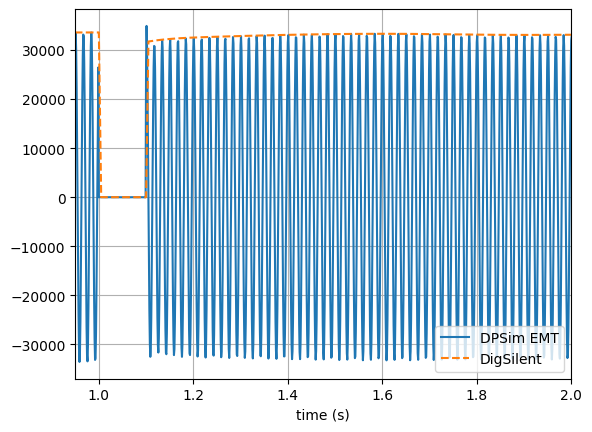

In [13]:
import matplotlib.pyplot as plt
timestep_common = 1e-3

plt.plot(ts_dpsim_emt['Bus_0014.V_0'].interpolate(timestep_common).time, np.sqrt(3/2) * ts_dpsim_emt['Bus_0014.V_0'].interpolate(timestep_common).values, label='DPSim EMT')
plt.plot(ts_powerfactory['Bus_0014'].interpolate(timestep_common).time, ts_powerfactory['Bus_0014'].interpolate(timestep_common).abs().values * 33000, '--', label='DigSilent')

plt.legend(loc='lower right')
plt.xlabel('time (s)')
#plt.ylabel(ylabels[varname_dpsim])
plt.grid()
plt.xlim([0.95, 2])
#plt.xlim([-0.001, 0.1])
#plt.ylim([135e3, 145e3])
#plt.ylim([32e3, 36e3])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

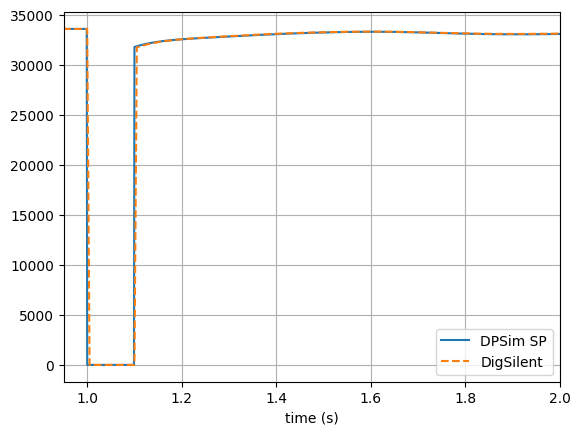

In [14]:
timestep_common = 1e-3

plt.plot(ts_dpsim_sp['Bus_0014.V'].interpolate(timestep_common).time, ts_dpsim_sp['Bus_0014.V'].interpolate(timestep_common).abs().values, label='DPSim SP')
plt.plot(ts_powerfactory['Bus_0014'].interpolate(timestep_common).time, ts_powerfactory['Bus_0014'].interpolate(timestep_common).values * 33000, '--', label='DigSilent')
plt.legend(loc='lower right')
plt.xlabel('time (s)')
#plt.ylabel(ylabels[varname_dpsim])
plt.grid()
plt.xlim([0.95, 2])
#plt.xlim([0.0, 0.1])
#plt.ylim([135e3, 145e3])
#plt.ylim([32e3, 36e3])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

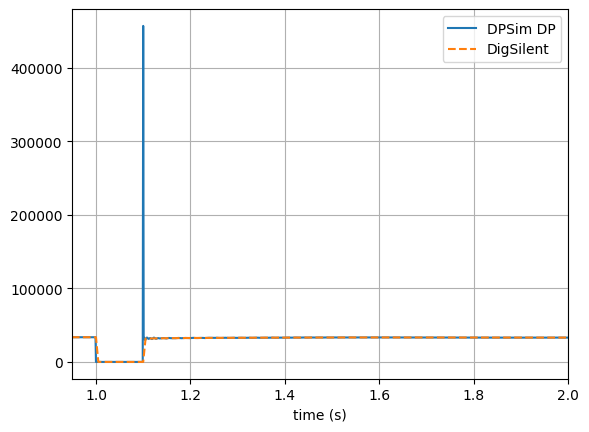

In [15]:
timestep_common = 1e-3

plt.plot(ts_dpsim_dp['Bus_0014.V'].interpolate(timestep_common).time, ts_dpsim_dp['Bus_0014.V'].interpolate(timestep_common).abs().values, label='DPSim DP')
plt.plot(ts_powerfactory['Bus_0014'].interpolate(timestep_common).time, ts_powerfactory['Bus_0014'].interpolate(timestep_common).values * 33000, '--', label='DigSilent')
plt.legend(loc='upper right')
plt.xlabel('time (s)')
#plt.ylabel(ylabels[varname_dpsim])
plt.grid()
plt.xlim([0.95, 2])
#plt.xlim([0.0, 0.1])
#plt.ylim([135e3, 145e3])
#plt.ylim([32e3, 36e3])
plt.show